## TODO
1. Create simple two versions VAE arch for each CIFAR channel , one Single diagonal Gaussian  and other Mixtures of diagonal gaussians

2. modify reparam and logprob fn from original MNIST CVAE example

3. Run to generate samples and calculate ELBO, RMSE , and other Gen Models measures, such as inception score

4. focus on out of sample measures, as this focuses on the core of vae, generalization ability


In [1]:
%config Completer.use_jedi = False
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow
import tensorflow_probability as tfp
import plotly.express as px
import pandas as pd
from sklearn.mixture import GaussianMixture
import seaborn as sns

import time

seed = 1
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
def preprocess_images(images,channel):
    images = images[:,:,:,channel]
    images = images.reshape((images.shape[0], 32, 32, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')
channel = 0
train_images = preprocess_images(train_images,channel)
test_images = preprocess_images(test_images,channel)

In [4]:
"""
Refs
Introduction to graphs and tf.function
https://www.tensorflow.org/guide/intro_to_graphs#using_tffunction
"""
class dense_diag_gaus_autoencoder(Model):
    def __init__(self, latent_dim):
        super(dense_diag_gaus_autoencoder, self).__init__()
        self.logger = logging.getLogger('dense_diag_gaus_autoencoder')
        self.latent_dim = latent_dim
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        self.dtype_ = tf.float64
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(32,32,1),dtype=self.dtype_),
            layers.Flatten(),
            layers.Dense(latent_dim+latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(self.latent_dim),dtype=self.dtype_),
            layers.Dense(32*32, activation='sigmoid'),
            layers.Reshape((32, 32,1))
        ])
        
        self.logger.info('Encoder')
        self.logger.info(self.encoder.summary())
        
        self.logger.info('Decoder')
        self.logger.info(self.decoder.summary())
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)


    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar


    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean


    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    @staticmethod
    def log_normal_pdf(sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)

    @staticmethod
    def compute_loss(model, x):
        logger = logging.getLogger('compute_loss')
        mean, logvar = model.encode(x)
        z = model.reparameterize(mean, logvar)
        x_logit = model.decode(z)
        # x_logit = tf.cast(x=x_logit,dtype=tf.float64)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = dense_diag_gaus_autoencoder.log_normal_pdf(z, 0., 0.)
        logqz_x = dense_diag_gaus_autoencoder.log_normal_pdf(z, mean, logvar)
        
#         logpx_z = tf.cast(logpx_z,tf.float64)
#         logpz = tf.cast(logpz,tf.float64)
#         logqz_x = tf.cast(logqz_x,tf.float64)
        
        return -tf.reduce_mean(logpx_z + logpz - logqz_x)

    
    @staticmethod
    @tf.function
    def train_step(model, x, optimizer):
        """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        with tf.GradientTape() as tape:
            loss = dense_diag_gaus_autoencoder.compute_loss(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [5]:
train_size = 60000
batch_size = 32
test_size = 10000
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 64
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = dense_diag_gaus_autoencoder(latent_dim)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
Total params: 131,200
Trainable params: 131,200
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              66560     
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 1)         0         
Total params: 66,560
Trainable params: 66,560
Non-trainable params: 0
_________________________________________________________________


In [6]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(test_sample[i, :, :,0], cmap='gray')
        plt.axis('off')
    plt.show()
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :,0], cmap='gray')
        plt.axis('off')
    plt.show()
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [7]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [8]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
test_sample = None
for test_batch in test_dataset.take(1000):
    if test_sample is None:
        test_sample = test_batch[0:num_examples_to_generate, :, :,0]
    else:
        tmp = test_batch[0:num_examples_to_generate, :, :, 0]
        test_sample = tf.concat([test_sample,tmp],axis=0)
test_sample.shape

TensorShape([5008, 32, 32])

In [9]:
shape = test_sample.shape.as_list()
shape.append(1)
test_sample_reshaped = tf.reshape(tensor=test_sample,shape=shape)
test_sample_reshaped.shape

TensorShape([5008, 32, 32, 1])

In [10]:
# z1 = model.encode(test_sample)

In [11]:
train_images.dtype


dtype('float32')

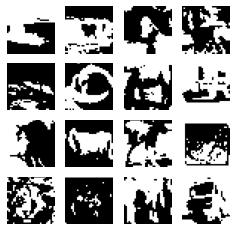

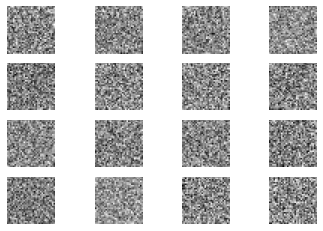

<Figure size 432x288 with 0 Axes>

Epoch: 1, Test set ELBO: -715.5740356445312, time elapse for current epoch: 2.914647102355957


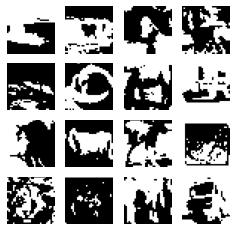

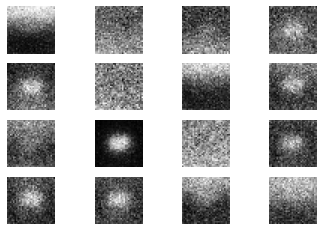

<Figure size 432x288 with 0 Axes>

Epoch: 2, Test set ELBO: -695.9149780273438, time elapse for current epoch: 1.8370423316955566


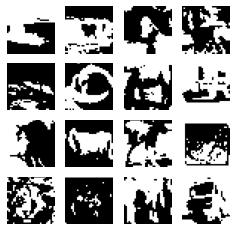

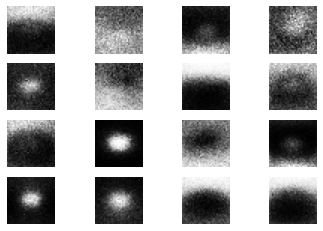

<Figure size 432x288 with 0 Axes>

Epoch: 3, Test set ELBO: -686.0318603515625, time elapse for current epoch: 1.793168067932129


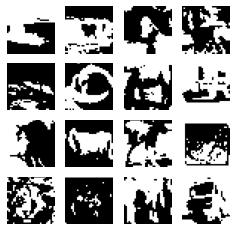

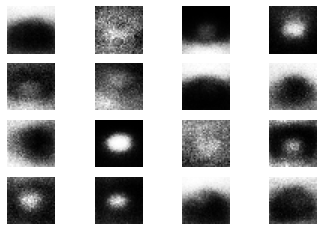

<Figure size 432x288 with 0 Axes>

Epoch: 4, Test set ELBO: -678.7318115234375, time elapse for current epoch: 1.835278034210205


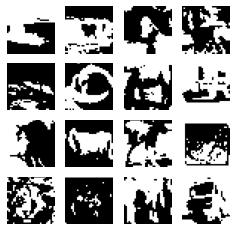

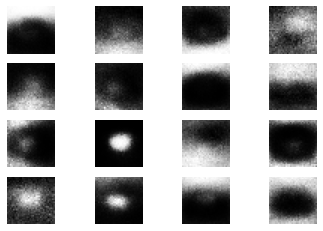

<Figure size 432x288 with 0 Axes>

Epoch: 5, Test set ELBO: -673.5048828125, time elapse for current epoch: 1.8877146244049072


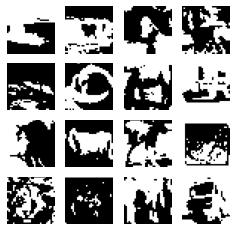

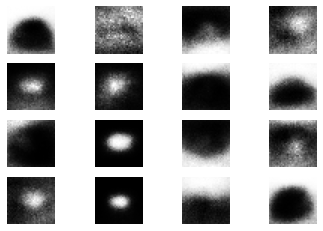

<Figure size 432x288 with 0 Axes>

Epoch: 6, Test set ELBO: -668.098876953125, time elapse for current epoch: 1.817798137664795


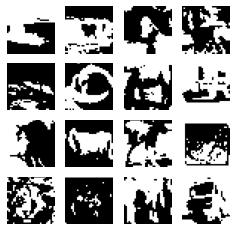

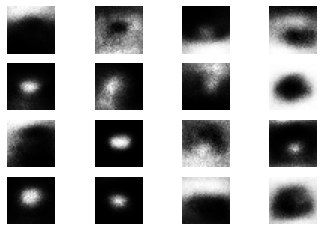

<Figure size 432x288 with 0 Axes>

Epoch: 7, Test set ELBO: -664.3272094726562, time elapse for current epoch: 1.7970061302185059


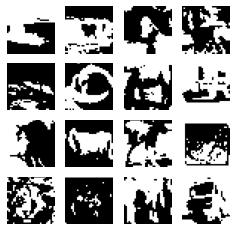

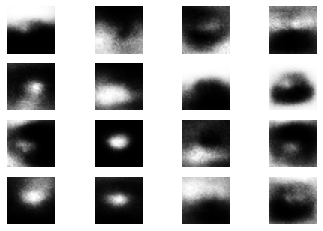

<Figure size 432x288 with 0 Axes>

Epoch: 8, Test set ELBO: -660.9948120117188, time elapse for current epoch: 1.709007740020752


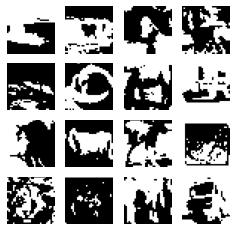

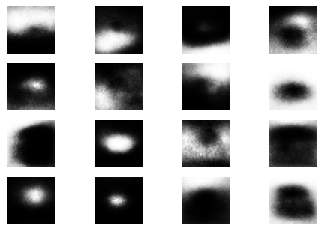

<Figure size 432x288 with 0 Axes>

Epoch: 9, Test set ELBO: -658.220458984375, time elapse for current epoch: 1.8641347885131836


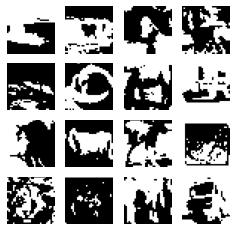

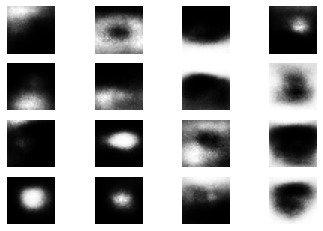

<Figure size 432x288 with 0 Axes>

Epoch: 10, Test set ELBO: -656.0968017578125, time elapse for current epoch: 1.6656968593597412


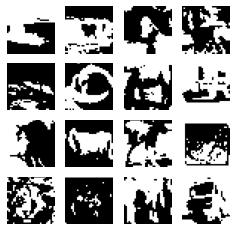

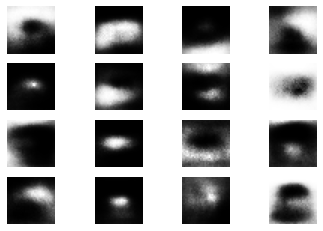

<Figure size 432x288 with 0 Axes>

In [12]:
generate_and_save_images(model, 0, test_sample_reshaped)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:

        dense_diag_gaus_autoencoder.train_step(model, train_x, model.optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(dense_diag_gaus_autoencoder.compute_loss(model, test_x))
    elbo = -loss.result()
    # display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
          .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample_reshaped)